In [1]:
# import open3d as o3d
import numpy as np
# from open3d.examples import open3d_example as o3dtut
from stl import mesh
%matplotlib widget
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
%load_ext autoreload
%autoreload 2

In [2]:
data = torch.load("data_attacked/e-mesh-perpendicular/dgcnn/ATK_2023_09_28__00_26_04.pt")
#data = torch.load("data_dict.pt")

# data = np.load("all_data_5.npy", allow_pickle=True).item()

# data.keys()
# data["pc"] = data["pc"].squeeze()
# item = data


# data['pc'].shape

In [2]:
LABELS = ['bareteeth', 'cheeks_in', 'eyebrow', 'high_smile',
          'lips_back', 'lips_up', 'mouth_down', 'mouth_extreme',
          'mouth_middle', 'mouth_open', 'mouth_side', 'mouth_up']
LABEL_STR2INT = {label:i for i,label in enumerate(LABELS)}
LABEL_INT2STR = {i:label for i,label in enumerate(LABELS)}

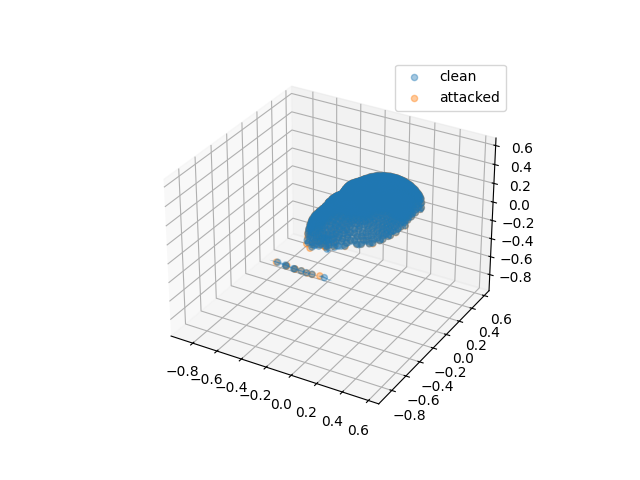

In [5]:
idx = 30

item = data[idx]

pc_clean = item["pc"]
pc_attacked = item["attacked"]
shift = item["shift"].squeeze()
scale = item["scale"].squeeze()

# pc_clean = pc_clean*scale + shift 
# pc_attacked = pc_attacked*scale + shift 

# pc_attacked = (pc_attacked - shift) / scale
#true_label = item["cate"].item()
#clean_pred = item["clean_pred"].item()
#attack_pred = item["attack_pred"].item()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.add_collection3d(mplot3d.art3d.Poly3DCollection(item["meshvectors"], alpha=0.6))
#Add the 3D faces to the created matplotlib axes
min_val = item["meshvectors"].reshape(-1).min()
max_val = item["meshvectors"].reshape(-1).max()
# Find min & max units to plate the 
ax.auto_scale_xyz([min_val, max_val],[min_val, max_val],[min_val, max_val])

#print("True label:", LABEL_INT2STR[true_label])
#print("Clean pred:", LABEL_INT2STR[clean_pred])
#print("Attack pred:", LABEL_INT2STR[attack_pred])
# print(LABEL_INT2STR[item["target"].item()])
ax.scatter3D(pc_clean[:,0], pc_clean[:,1], pc_clean[:,2], label="clean", alpha=0.4)
ax.scatter3D(pc_attacked[:,0], pc_attacked[:,1], pc_attacked[:,2], label="attacked", alpha=0.4)
plt.legend()
plt.show()

In [3]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from datetime import datetime
import os

from dataset.coma2 import Coma
from classifiers import DGCNN_cls
from attacks import EpsMeshAttack

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DGCNN_cls().to(device)
weights = torch.load("runs/Sep22_05-10-02_yusuf/best-model.pt")
model.load_state_dict(weights)
model.eval()

dataset = Coma(partition="test")
test_loader = DataLoader(dataset, batch_size=1, shuffle=False, drop_last=False)
atk = EpsMeshAttack(model=model, device=device, projection="central", eps=1e-7, alpha=0.01, steps=100, seed=0)
batch = next(iter(test_loader))

5


In [8]:
atk.attack(batch['pc'], labels=batch['cate'], meshvectors=batch['meshvectors'], meshnormals=batch['meshnormals'])

tensor([[[ 0.1870,  0.2010,  0.1985],
         [ 0.0352, -0.0087,  0.2780],
         [ 0.0229, -0.0389,  0.3140],
         ...,
         [ 0.1489, -0.1671,  0.1597],
         [ 0.0531, -0.0959,  0.2600],
         [ 0.0345, -0.1069,  0.2681]]], device='cuda:0')

In [9]:
attacked_batch = atk.save(test_loader, root=None)

batch 0/120
batch 1/120
batch 2/120
batch 3/120
batch 4/120
batch 5/120
batch 6/120
batch 7/120
batch 8/120
batch 9/120
batch 10/120
batch 11/120
batch 12/120
batch 13/120
batch 14/120
batch 15/120
batch 16/120
batch 17/120
batch 18/120
batch 19/120
batch 20/120
batch 21/120
batch 22/120
batch 23/120
batch 24/120
batch 25/120
batch 26/120
batch 27/120
batch 28/120
batch 29/120
batch 30/120
batch 31/120
batch 32/120
batch 33/120
batch 34/120
batch 35/120
batch 36/120
batch 37/120
batch 38/120
batch 39/120
batch 40/120
batch 41/120
batch 42/120
batch 43/120
batch 44/120
batch 45/120
batch 46/120
batch 47/120
batch 48/120
batch 49/120
batch 50/120
batch 51/120
batch 52/120
batch 53/120
batch 54/120
batch 55/120
batch 56/120
batch 57/120
batch 58/120
batch 59/120
batch 60/120
batch 61/120
batch 62/120
batch 63/120
batch 64/120
batch 65/120
batch 66/120
batch 67/120
batch 68/120
batch 69/120
batch 70/120
batch 71/120
batch 72/120
batch 73/120
batch 74/120
batch 75/120
batch 76/120
batch 77/

In [4]:
for k,v in batch.items(): 
    print(f"k:{k} \t v:{v.shape}")

k:meshvectors 	 v:torch.Size([1, 4182, 3, 3])
k:meshnormals 	 v:torch.Size([1, 4182, 3])
k:cate 	 v:torch.Size([1])
k:pc 	 v:torch.Size([1, 4182, 3])
k:shift 	 v:torch.Size([1, 1, 3])
k:scale 	 v:torch.Size([1])


In [22]:
attacked_batch[0]['attacked'].shape

torch.Size([4182, 3])

In [15]:
data = batch['pc'].clone().detach().to(device)
labels = batch['cate'].clone().detach().to(device)
meshvectors = batch['meshvectors'].clone().detach().to(device)
meshnormals = batch['meshnormals'].clone().detach().to(device)
center = meshvectors.mean(dim=2).unsqueeze(2)
# meshvectors: (B, N, v, d); meshnormals: (B, N, d); barycenters: (B, N, d)
eps = 0.1
if eps < 1.0:
    meshvectors = center + eps*(meshvectors - center)
    

In [23]:
dist = torch.norm(meshvectors - center, p=2, dim=3, keepdim=True)

In [24]:
dist.shape

torch.Size([1, 4182, 3, 1])

In [28]:
max_dist = torch.max(dist, dim=2)[0]
max_dist

tensor([[[0.0026],
         [0.0006],
         [0.0007],
         ...,
         [0.0016],
         [0.0016],
         [0.0016]]], device='cuda:0')

In [31]:
n_step = 50
alphas = max_dist / (50//1.5)
alphas.shape

torch.Size([1, 4182, 1])

True label: eyebrow
Clean pred: eyebrow
Attack pred: mouth_up


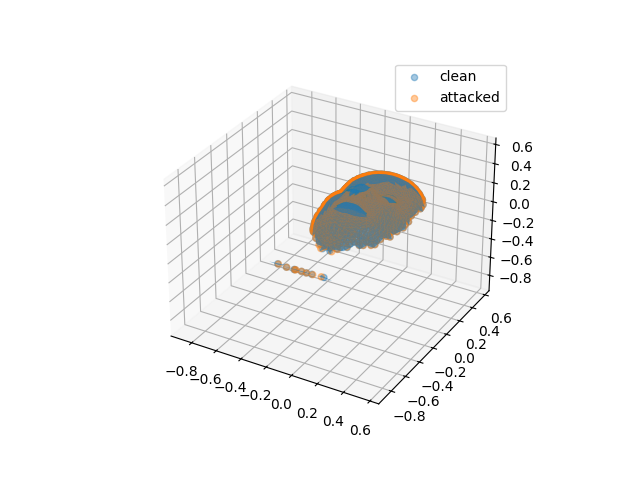

In [21]:
idx = 50

item = attacked_batch[idx]

pc_clean = item["pc"]
pc_attacked = item["attacked"]
shift = item["shift"].squeeze()
scale = item["scale"].squeeze()

# pc_clean = pc_clean*scale + shift 
# pc_attacked = pc_attacked*scale + shift 

# pc_attacked = (pc_attacked - shift) / scale
true_label = item["cate"].item()
clean_pred = item["clean_pred"].item()
attack_pred = item["attack_pred"].item()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.add_collection3d(mplot3d.art3d.Poly3DCollection(item["meshvectors"], alpha=0.6))
#Add the 3D faces to the created matplotlib axes
min_val = item["meshvectors"].reshape(-1).min()
max_val = item["meshvectors"].reshape(-1).max()
# Find min & max units to plate the 
ax.auto_scale_xyz([min_val, max_val],[min_val, max_val],[min_val, max_val])

print("True label:", LABEL_INT2STR[true_label])
print("Clean pred:", LABEL_INT2STR[clean_pred])
print("Attack pred:", LABEL_INT2STR[attack_pred])
# print(LABEL_INT2STR[item["target"].item()])
ax.scatter3D(pc_clean[:,0], pc_clean[:,1], pc_clean[:,2], label="clean", alpha=0.4)
ax.scatter3D(pc_attacked[:,0], pc_attacked[:,1], pc_attacked[:,2], label="attacked", alpha=0.4)
plt.legend()
plt.show()

In [15]:
batch['meshnormals'].shape

torch.Size([1, 4182, 3])

In [19]:
batch['shift'].shape

torch.Size([1, 1, 3])

In [6]:
batch['meshvectors'].shape

torch.Size([1, 4182, 3, 3])